In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv
/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip


In [2]:
# pandas library -> 데이터 전처리할 때 많이 사용
# zip 파일 -> 파일 하나만 있을 때 그냥 경로 넣어도 상관 없음
# 여러 개의 파일이 압축되어 있을 때 -> 압축 풀어줘야 함
train = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip")
train.head()

# Weekly_Sales 값 예측하는 모델 만드는 것이 목표 
# 가설 : 공휴일(Holiday)일 때 Sale이 올라갈 것이다 -> EDA 해보기

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [3]:
test = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip")
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


데이터 형식이 '숫자'로 들어가 있어야지 학습이 가능하다(타 형태일 시 모델이 이해를 하지 못함)    
-> 모든 column들의 값들이 숫자 형태를 띄도록 변화  
-> 해당 데이터는 Date column이 string 형식으로 들어가 있음

In [4]:

train.dtypes # 각 column의 데이터 형식 출력

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [5]:
## 판다스 데이터 형식을 object 형식을 날짜 형태로 변환 -> 연도, 월, 일 정보 추출 가능
train['Date'] = pd.to_datetime(train['Date'])
train['Year'] = train['Date'].dt.year #.dt -> 날짜 데이터 가져오고 싶다
train['Month'] = train['Date'].dt.month
train

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,Month
0,1,1,2010-02-05,24924.50,False,2010,2
1,1,1,2010-02-12,46039.49,True,2010,2
2,1,1,2010-02-19,41595.55,False,2010,2
3,1,1,2010-02-26,19403.54,False,2010,2
4,1,1,2010-03-05,21827.90,False,2010,3
...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,2012,9
421566,45,98,2012-10-05,628.10,False,2012,10
421567,45,98,2012-10-12,1061.02,False,2012,10
421568,45,98,2012-10-19,760.01,False,2012,10


In [6]:
test['Date'] = pd.to_datetime(test['Date'])
test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test

,Store,Dept,Date,IsHoliday,Year,Month
0,1,1,2012-11-02,False,2012,11
1,1,1,2012-11-09,False,2012,11
2,1,1,2012-11-16,False,2012,11
3,1,1,2012-11-23,True,2012,11
4,1,1,2012-11-30,False,2012,11
...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,2013,6
115060,45,98,2013-07-05,False,2013,7
115061,45,98,2013-07-12,False,2013,7
115062,45,98,2013-07-19,False,2013,7


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Month', ylabel='Weekly_Sales'>

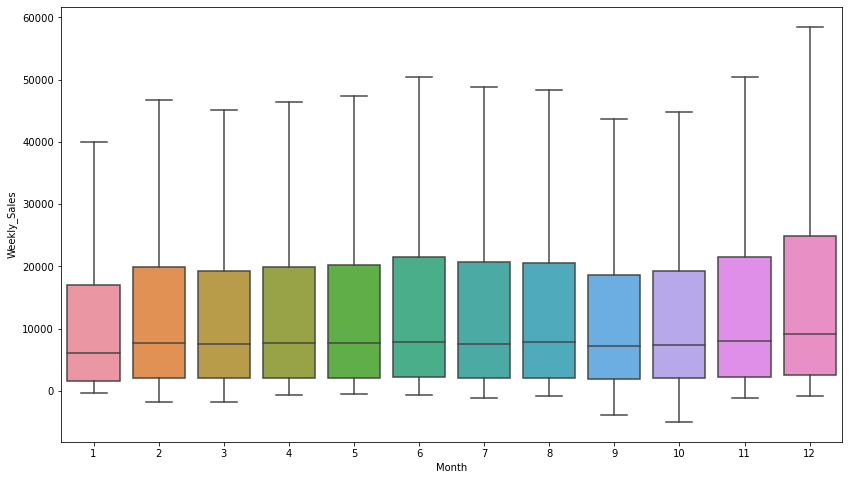

In [7]:
# 예측 column과의 연관성 보기

import seaborn as sns
import matplotlib.pyplot as plt

# 그림의 사이즈 지정하기
plt.figure(figsize = (14, 8))
# 어떤 column이 중요한지
# 정답 column과 비교해 Month 데이터가 영향이 있는지
# showfliers = False -> outliers, 튀는 애들 안 보이게 하기
sns.boxplot(train['Month'],train['Weekly_Sales'], showfliers = False)

그래프를 보았을 때 각 월별로 median, 상위 25%의 Sales 수치가 다르다 <br>
-> 월에 따라 Sales 수치가 변화한다, 예측할 때 월 정보가 유의미하게 적용할 수 있다는 것을 유추해볼 수 있다. <br>
-> 판매량이 '음수'인 경우가 있다는 것을 확인: 특정 월에 반품이 많이 들어오거나 환불이 더 많이 들어온 경우 음수의 Sales 값이 나올 수 있다. 

In [8]:
# train, test -> 모델에 집어넣는 형태 같아야 한다
# train 에서 column지웠을 시 test에서도 지워야 한다

train2 = train.drop(columns = ['Date', 'Weekly_Sales']) # date, sales column 삭제
train2.head()

,Store,Dept,IsHoliday,Year,Month
0,1,1,False,2010,2
1,1,1,True,2010,2
2,1,1,False,2010,2
3,1,1,False,2010,2
4,1,1,False,2010,3


In [9]:
test2 = test.drop(columns = 'Date')
test2.head()

,Store,Dept,IsHoliday,Year,Month
0,1,1,False,2012,11
1,1,1,False,2012,11
2,1,1,False,2012,11
3,1,1,True,2012,11
4,1,1,False,2012,11


모델 4가지 과정 기억하기!!

1. 모델 불러오기 -> 여러가지 모델 중 어떤 모델 사용? 어떤 데이터셋에 어떤 모델 쓰는 것이 최적?  
    모델 잘 모름 -> 일단 사용 난이도 낮고 성능이 준수하게 나오는 모델: Random Forest
2. 모델 정의하기
3. 모델 학습시키기
4. 모델 예측하기

In [11]:
# Random Forest 앙상블 모델
# 회귀문제 -> Regressor 사용
# 예측값이 다중 클래스 분류인지 어떤 특정 값을 예측하는 것인지에 따라 Regressor/Classifier 선택
# 
%time # train하는데 걸리는 시간 출력
from sklearn.ensemble import RandomForestRegressor 

# 모델 선언 
rf = RandomForestRegressor(n_jobs = 4)

# 모델 학습
rf.fit(train2, train['Weekly_Sales']) # .fit(독립변수들, 정답 column) 안에 학습용 데이터를 넣어 모델을 학습시킨다

# 모델 예측 
result = rf.predict(test2) 
result

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


array([25524.03209659, 25524.03209659, 25524.03209659, ...,
         714.88621495,   714.88621495,   714.88621495])

In [12]:
sub = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip")
sub.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,0
1,1_1_2012-11-09,0
2,1_1_2012-11-16,0
3,1_1_2012-11-23,0
4,1_1_2012-11-30,0


In [13]:
sub['Weekly_Sales'] = result
sub.head() # 예측값 잘 들어갔는지 확인하기

,Id,Weekly_Sales
0,1_1_2012-11-02,25524.032097
1,1_1_2012-11-09,25524.032097
2,1_1_2012-11-16,25524.032097
3,1_1_2012-11-23,21950.538378
4,1_1_2012-11-30,25524.032097


In [14]:
# submission file .csv 파일로 보내기
# 데이터프레임 형식 csv로 변환

# index = 0 or index = False 적지 않으면 기본값으로 index = True 설정되어 있음
# index = True일 때 sub dataframe의 인덱스가 column으로 변환되어서 나오게됨 
sub.to_csv("submission_month.csv",index = False) 

점수가 잘 나오지 않았을 때? (크게 2가지 이유)   
1. 모델 선택을 잘못했을 때  
2. 전처리를 잘못했을 때 

제출 할 수 있는 횟수가 정해져 있었을 때 
-> 내부적으로 모델 점수 볼 수 있어야 함     
use validation set

month column 추가 후 점수가 갑가지 확 뛰었다? -> 이상함 느껴야 한다
- 대회의 평가방식에서 뭐를 중요하게 생각하는가? 
- 회사마다 모든 고객이 중요하지 않음(ex 게임회사한테는 과금유저, 장시간 게이머들이 더 중요)
- Walmart: Holiday 기간 Sales의 예측을 중요하게 여김 (해당 부분 점수 산출시 weight 크게 줌)
- Month column 추가시 어떤 공휴일에 판매가 잘 되는지 예측이 가능해짐
- Month 가 뭔지는 몰라도 12이고 Holiday가 True일때 판매량이 늘어난다는 것을 학습하게 됨
